## 1. Dataset Information

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import os
from great_tables import GT
import matplotlib as mpl
from cycler import cycler

In [2]:
plt.style.use("presentation.mplstyle")
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#5c3c8b', '#92c36d', '#ee9432', '#496391', '#85a5cd', '#FDF3CC'])
plotsize = 5

### Load data

In [3]:
filename = "0_raw_data_sets/featurized_imputed_data.csv"
df = pd.read_csv(filename, index_col=0)

df = df[df['BASE_Category'] != 'misc']
df["dH (kcal/mol)"] = df["dH (kJ/mol)"] / 4.184
df["dS (cal/mol/K)"] = df["dS (J/mol/K)"] / 4.184

df_orig = df.copy()

# Making sure that everything is unique
tags = []
for _, row in df.iterrows():
    tag = row['BASE_State'] + row['BASE_Category'] + row['Canonical SMILES'] + str(row['Solvent'])
    tags.append(tag)
assert(len(tags) == len(set(tags)))

In [4]:
# output filename
output_dir = '1_dataset_images'

# create directory for saving plots if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Save information about datasets
Includes total data points, molecule occurences, and phase and category occurences. 

In [5]:
# Show molecule counts, phase counts, overlap between ΔH and ΔS
df_split_dict = {
    "enthalpy": df.dropna(subset=['dH (kJ/mol)']),
    "entropy": df.dropna(subset=['dS (J/mol/K)']),
    "has_both": df.dropna(subset=['dH (kJ/mol)', 'dS (J/mol/K)']),
}

In [6]:
for prop, df_spec in df_split_dict.items():
    file_path = os.path.join(output_dir, f"{prop}_report.txt")
    
    with open(file_path, "w") as file:
        # Print total number of data points
        file.write(f"Total data points: {len(df_spec)}\n\n")

        phase_counts = df.groupby("Canonical SMILES")["BASE_Monomer_State"].nunique()
        total_molecules = phase_counts.shape[0]
        multi_phase = (phase_counts > 1).sum()
        single_phase = (phase_counts == 1).sum()

        file.write(f"Unique molecules: {total_molecules}\n")
        file.write(f"Single-occurence molecules: {single_phase}\n")
        file.write(f"Multi-occurence molecules: {multi_phase}\n\n")

        # Count different polymerization types
        mechanisms = df_spec["BASE_Category"].unique().tolist()
        mechanism_counts = []

        file.write("Category      | Occurences\n")
        file.write("-" * 14 + "|------------\n")

        for mechanism in mechanisms:
            count = df_spec["BASE_Category"].value_counts()[mechanism]
            mechanism_counts.append(count)
            formatted_line = f"{mechanism.ljust(13)} | {str(count)}\n"
            file.write(formatted_line)

        # Count unique monomer states
        monomer_states = df_spec["BASE_Monomer_State"].unique().tolist()
        monomer_counts = []

        file.write("\n\nMonomer State | Occurences\n")
        file.write("-" * 14 + "|------------\n")

        for state in monomer_states:
            count = df_spec["BASE_Monomer_State"].value_counts()[state]
            monomer_counts.append(count)
            formatted_line = f"{state.ljust(13)} | {str(count)}\n"
            file.write(formatted_line)

### Histogram colored by phase

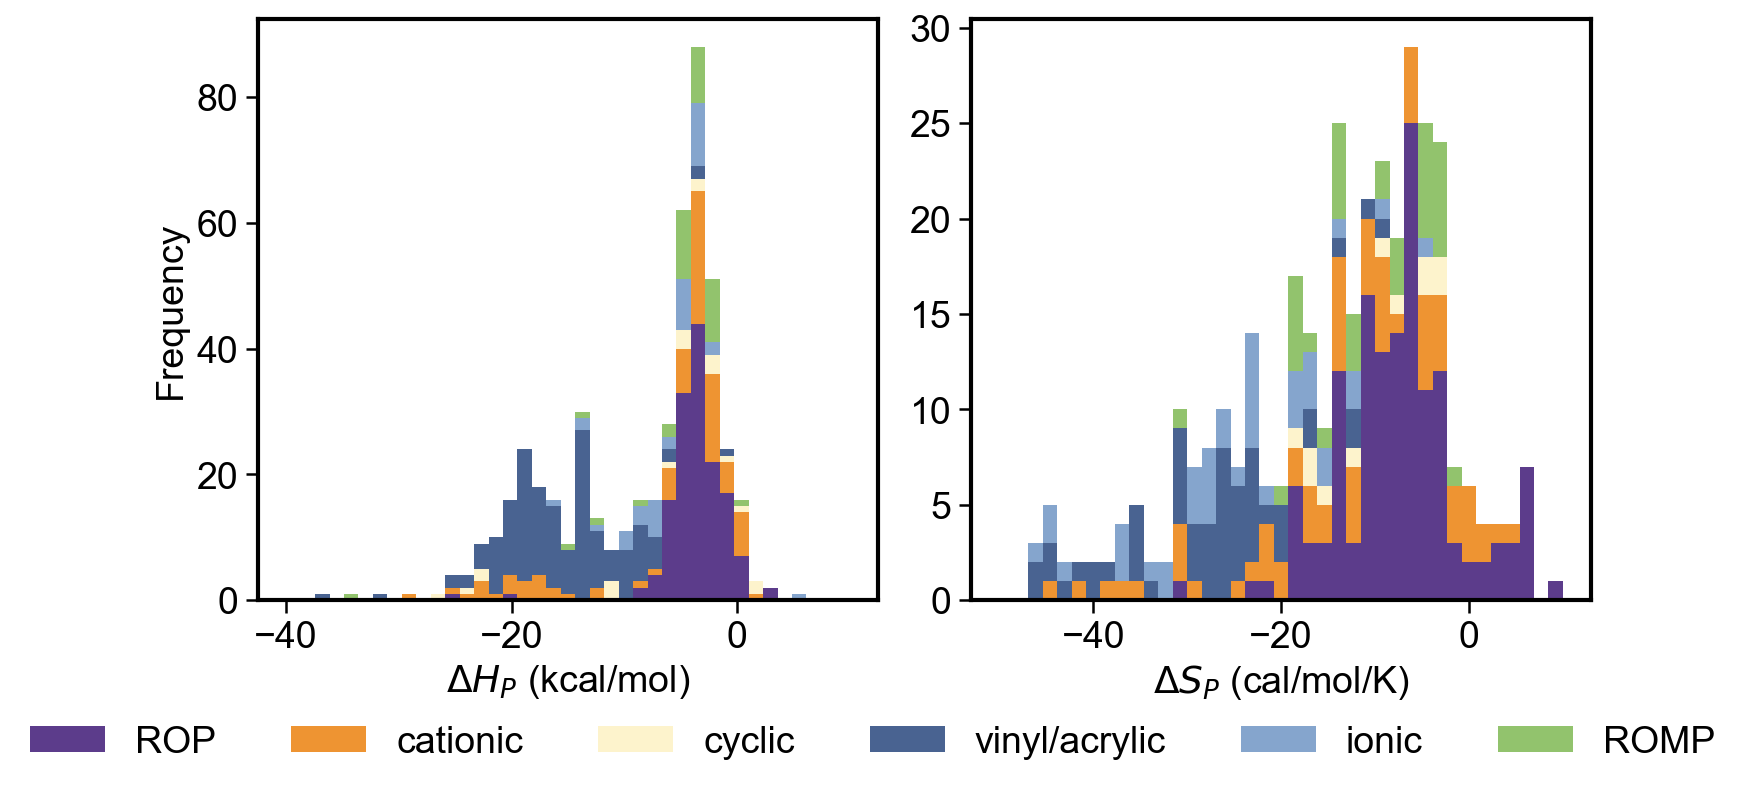

In [7]:
plt.rcParams.update({'font.size': 14, 'font.family': 'sans-serif'})

category_colors = {
    'ROP': "#5c3c8b",
    'ROMP': "#92c36d",
    'cationic': "#ee9432",
    'vinyl/acrylic': "#496391",
    'misc': '#ffffff',
    'ionic': "#85a5cd",
    'cyclic': "#FDF3CC",
}

categories = [category for category in df['BASE_Category'].unique() if category != 'misc']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*plotsize, plotsize))

dH_data = [df[df['BASE_Category'] == category]["dH (kcal/mol)"] for category in categories]
dS_data = [df[df['BASE_Category'] == category]["dS (cal/mol/K)"] for category in categories]

ax1.hist(dH_data, np.linspace(-40, 10, 40), color=[category_colors[cat] for cat in categories], stacked=True)
ax1.set(xlabel=r"$\Delta H_P$ (kcal/mol)")

ax2.hist(dS_data, np.linspace(-50, 10, 40), color=[category_colors[cat] for cat in categories], stacked=True)
ax2.set(xlabel=r"$\Delta S_P$ (cal/mol/K)")

ax1.set(ylabel=r"Frequency")

# Add legend below both plots, centered, in one line
fig.legend(categories, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=len(categories), frameon=False)

plt.tight_layout()
plt.savefig(f"{output_dir}/dH_dS_stacked_hist_kcal.png", dpi=300, bbox_inches='tight')
plt.show()

### Scatter plot of H vs S (for points that have both available)

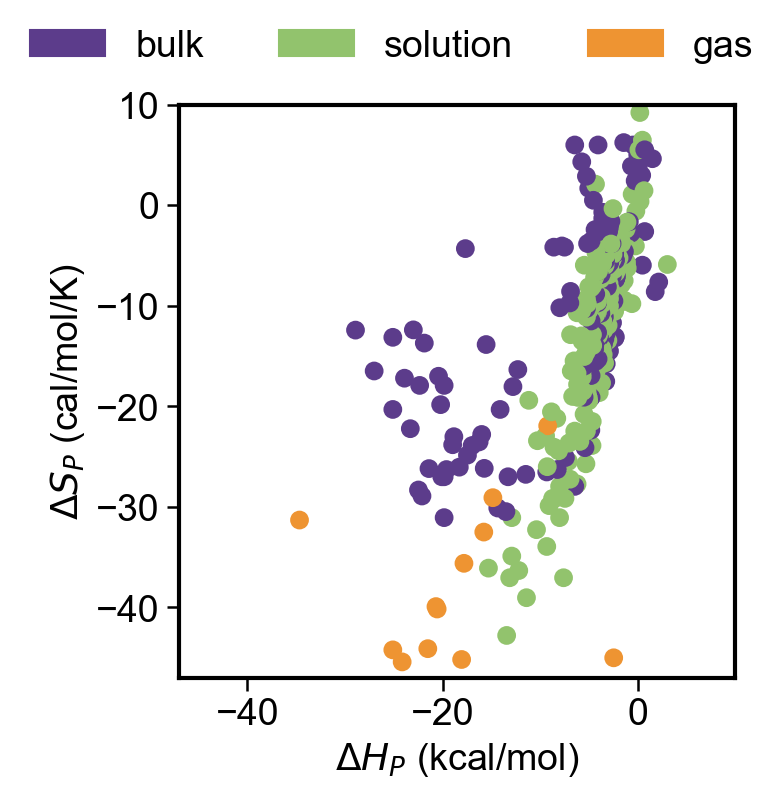

In [8]:
state_colors = {
    'l': "#5c3c8b",
    's': "#92c36d",
    'g': "#ee9432",
}
phase_labels = {'l': 'bulk', 's': 'solution', 'g': 'gas'}

states = [s for s in df['BASE_Monomer_State'].unique()]

fig, ax = plt.subplots(figsize=(plotsize, plotsize))

plt.scatter(df_split_dict['has_both']["dH (kcal/mol)"], df_split_dict['has_both']['dS (cal/mol/K)'], c=df_split_dict['has_both']['BASE_Monomer_State'].map(state_colors))

plt.xlabel(r"$\Delta H_P$ (kcal/mol)")
plt.ylabel(r"$\Delta S_P$ (cal/mol/K)")

plt.xlim(-47, 10)
plt.ylim(-47, 10)

handles = [mpatches.Patch(color=color, label=phase_labels[phase]) for phase, color in state_colors.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(state_colors), bbox_to_anchor=(0.5, 0.95))


plt.tight_layout()
plt.savefig(f"{output_dir}/dH_dS_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

### Misc figures

In [9]:
# PEP vs no PEP

data = {
    "": [i+1 for i in range(8)],
    
    "Fingerprint Subset": ["state and category", "Hf - GAV", "Dipole Moment", "Solute Parameters", "RDKit 2D", "Sterics", "Solvation Thermo", "Tanimoto Similarity"],
    "Input": ["string", "monomer SMILES", "monomer SMILES", "monomer SMILES", "monomer SMILES", "repeat unit SMILES", "both SMILES", "both SMILES"],
    "Type": ["bool", "float", "float", "float", "float", "float", "float", "float"],
    "Source": ["literature", "pgthermo", "openbabel", "RMG ML + GC", "RDKit", "-", "RMG ML", "RDKit"],
    "# Features": [9, 4, 1, 12, 210, 9, 5, 1],
}

gt = GT(pd.DataFrame(data)).cols_align(align="center")


gt = gt.opt_horizontal_padding(scale=2)
gt = gt.opt_vertical_padding(scale=1)

gt = (
    gt
    .tab_options(
        container_width = "100%",
        # table_background_color="lightblue",
        # heading_background_color = "gold",
        column_labels_background_color="#C0ABDC",
        # row_group_background_color="lightyellow",
        # stub_background_color="lightgreen",
        # source_notes_background_color="#f1e2af",
    )
)

gt = gt.tab_options(
    column_labels_border_top_color="black",
    column_labels_border_top_style="solid",
    column_labels_border_top_width="2px",

    column_labels_border_bottom_color="black",
    column_labels_border_bottom_style="solid",
    column_labels_border_bottom_width="2px",

    table_body_border_bottom_color="black",
    table_body_border_bottom_style="solid",
    table_body_border_bottom_width="2px",
)

gt = gt.tab_spanner_delim()
gt

gt.save("1_dataset_images/fingerprint_desc.png")

,Fingerprint Subset,Input,Type,Source,# Features
1,state and category,string,bool,literature,9
2,Hf - GAV,monomer SMILES,float,pgthermo,4
3,Dipole Moment,monomer SMILES,float,openbabel,1
4,Solute Parameters,monomer SMILES,float,RMG ML + GC,12
5,RDKit 2D,monomer SMILES,float,RDKit,210
6,Sterics,repeat unit SMILES,float,-,9
7,Solvation Thermo,both SMILES,float,RMG ML,5
8,Tanimoto Similarity,both SMILES,float,RDKit,1


In [10]:
# PEP vs no PEP

data = {
    "Quantity": ["ΔHf (n+1=5)","ΔHf (n=4)", r"ΔHf (monomer)", r"∆HP, GAV ="],
    "SMILES String Used": ["O=C(O)CCCCOC(=O)CCCCOC(=O)CCCCOC(=O)CCCCOC(=O)CCCCO", "O=C(O)CCCCOC(=O)CCCCOC(=O)CCCCOC(=O)CCCCO", "O=C1CCCCO1", ""],
    "pgthermo ΔHf (kcal/mol)": [-558.6, -457.3, -90.7, -10.6],
}

gt = GT(pd.DataFrame(data)).cols_align(align="left")


gt = gt.opt_horizontal_padding(scale=2)
gt = gt.opt_vertical_padding(scale=1)

gt = (
    gt
    .tab_options(
        container_width = "100%",
        # table_background_color="lightblue",
        # heading_background_color = "gold",
        column_labels_background_color="#C0ABDC",
        # row_group_background_color="lightyellow",
        # stub_background_color="lightgreen",
        # source_notes_background_color="#f1e2af",
    )
)

gt = gt.tab_options(
    column_labels_border_top_color="black",
    column_labels_border_top_style="solid",
    column_labels_border_top_width="2px",

    column_labels_border_bottom_color="black",
    column_labels_border_bottom_style="solid",
    column_labels_border_bottom_width="2px",

    table_body_border_bottom_color="black",
    table_body_border_bottom_style="solid",
    table_body_border_bottom_width="2px",
)

gt = gt.tab_spanner_delim()
gt

gt.save("1_dataset_images/pgthermo_demo.png")

Quantity,SMILES String Used,pgthermo ΔHf (kcal/mol)
ΔHf (n+1=5),O=C(O)CCCCOC(=O)CCCCOC(=O)CCCCOC(=O)CCCCOC(=O)CCCCO,-558.6
ΔHf (n=4),O=C(O)CCCCOC(=O)CCCCOC(=O)CCCCOC(=O)CCCCO,-457.3
ΔHf (monomer),O=C1CCCCO1,-90.7
"∆HP, GAV =",,-10.6
